# Part 4
# Author: Georgios Pligoropoulos < george@pligor.com >

In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
from os import path, remove
import numpy as np
import pandas as pd
from csv import QUOTE_ALL
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
import shutil
from sklearn.metrics import r2_score
from collections import OrderedDict
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from skopt.space.space import Integer, Real
from skopt import gp_minimize
from skopt.plots import plot_convergence
import pickle
import inspect
import dill
import sys
from sklearn.neighbors import NearestNeighbors
from datetime import datetime
import operator
from os.path import isfile, isdir, join
from os import getcwd
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeSVD, MICE, \
    MatrixFactorization, BiScaler
from math import floor
from scipy import stats

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
seed = 16011984
random_state = np.random.RandomState(seed=seed)
n_jobs = 1
%matplotlib inline

In [4]:
from advanced_one_hot_encoder import AdvancedOneHotEncoder

**Short sale** explained: http://www.investopedia.com/terms/r/real-estate-short-sale.asp

In [5]:
sns.set(font_scale=2)

## Load Data

In [6]:
twin_cities_path = join(getcwd(), 'twin_cities.csv')
df = pd.read_csv(twin_cities_path, delimiter = ',', encoding='utf-8', quoting=QUOTE_ALL, index_col=0)
df.shape

(1111, 20)

## Drop redundant columns
State column does not hold any information since it is the same for all instances
Also we are dropping last sale date as we are advised to not use it but also because it contains lots of nulls

In [7]:
if 'STATE' in df.columns:
    df = df.drop(labels=['STATE'], axis=1)
if 'LastSaleDate' in df.columns:
    df = df.drop(labels=['LastSaleDate'], axis=1)
df.shape

(1111, 18)

### Keep columns for Price Regression

In [8]:
#Regression Columns
#CITY, ZIP, BEDS, BATHS, SQFT, LotSize, YearBuilt, ParkingSpots, HasGarage, LATITUDE, LONGITUDE, ShortSale
XX = df[
    ['CITY', 'ZIP', 'BEDS', 'BATHS', 'SQFT', 'LotSize', 'YearBuilt', 'ParkingSpots', 'HasGarage', 'LATITUDE',
     'LONGITUDE', 'ShortSale']
]
XX.shape

(1111, 12)

In [9]:
#target: ListPrice
yy = df['ListPrice']
yy.shape

(1111,)

### Numerify data

In [10]:
if XX['BATHS'].dtype == 'object':
    XX['BATHS'] = [float(coord.replace(',', '.')) if isinstance(coord, basestring) else float(coord)
            for coord in XX['BATHS']]
XX['BATHS'].dtype

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


dtype('float64')

#### CITY

In [11]:
print len(XX['CITY'].unique())
XX['CITY'].unique()

6


array([u'St. Paul', u'Shoreview', u'Minneapolis', u'Woodbury',
       u'West St. Paul', u'Maplewood'], dtype=object)

In [12]:
if 'CITY' in XX.columns:
    XX = AdvancedOneHotEncoder().encodePandasColAndMerge(data_frame=XX, col_name='CITY')
XX.shape

(1111, 16)

#### ZIP

In [13]:
#comparing locations and zips lengths
print len(df['LOCATION'].unique())
print len(df['ZIP'].unique())

86
33


In [14]:
if 'ZIP' in XX.columns:
    XX = AdvancedOneHotEncoder().encodePandasColAndMerge(data_frame=XX, col_name='ZIP')
XX.shape

(1111, 47)

#### Year Built to Age

In [15]:
if 'YearBuilt' in XX.columns:
    XX['age'] = 2014 - XX['YearBuilt']
    XX.drop(labels='YearBuilt', axis=1, inplace=True)
assert 'age' in XX.columns
XX.shape

(1111, 47)

#### Has Garage to binary

In [16]:
XX['HasGarage'].unique()

array([u'Garage', u'No Garage'], dtype=object)

In [17]:
if 'Garage' in XX['HasGarage'].unique():
    XX['HasGarage'] = XX['HasGarage'] == 'Garage'
XX['HasGarage'].unique()

array([True, False], dtype=object)

#### Short Sale to binary

In [18]:
XX['ShortSale'].unique()

array([u'N', u'Y'], dtype=object)

In [19]:
if 'Y' in XX['ShortSale'].unique():
    XX['ShortSale'] = XX['ShortSale'] == 'Y'
XX['ShortSale'].unique()

array([False, True], dtype=object)

#### Latitude

In [20]:
if XX['LATITUDE'].dtype == 'object':
    XX['LATITUDE'] = [float(coord.replace(',', '.')) if isinstance(coord, basestring) else float(coord)
            for coord in XX['LATITUDE']]
XX['LATITUDE'].dtype

dtype('float64')

#### Longitude

In [21]:
if XX['LONGITUDE'].dtype == 'object':
    XX['LONGITUDE'] = [float(coord.replace(',', '.')) if isinstance(coord, basestring) else float(coord)
            for coord in XX['LONGITUDE']]
XX['LONGITUDE'].dtype

dtype('float64')

### Fill the Gaps
Rule of thumb of KNN to pick a neighborhood of 1%

In [22]:
k_factor = int(floor(len(XX) * 0.01))
k_factor

11

In [23]:
if sum(XX.isnull().sum()) > 0:
    XX[XX.columns] = KNN(k=k_factor).complete(XX.values)

Imputing row 1/1111 with 0 missing, elapsed time: 0.382
Imputing row 101/1111 with 1 missing, elapsed time: 0.383
Imputing row 201/1111 with 1 missing, elapsed time: 0.384
Imputing row 301/1111 with 0 missing, elapsed time: 0.385
Imputing row 401/1111 with 0 missing, elapsed time: 0.385
Imputing row 501/1111 with 0 missing, elapsed time: 0.386
Imputing row 601/1111 with 0 missing, elapsed time: 0.386
Imputing row 701/1111 with 0 missing, elapsed time: 0.387
Imputing row 801/1111 with 0 missing, elapsed time: 0.387
Imputing row 901/1111 with 0 missing, elapsed time: 0.388
Imputing row 1001/1111 with 0 missing, elapsed time: 0.388
Imputing row 1101/1111 with 0 missing, elapsed time: 0.389


In [24]:
sum(XX.isnull().sum())

0

# Question 4
We’re looking to understand what features of the home are most important to potentially
predicting the list price of a house. What has the strongest relationship to listing price:
square foot, lot size, or number of bedrooms? How do they compare? Please explain.

### Answer

Null hypothesis for regression:
We claim that a certain feature does not matter at all for predicting the price.

We execute linear regression once and we find our value for the slope.

Under the fact that the null hypothesis is true, we shuffle the pairs of input and target and we calculate the slope of linear regression again and again.

We compare: Are there are many values near zero?
If p-value is very small then we need to reject the null hypothesis that the certain features does not matter at all. It matters but we cannot say how much.

#### price

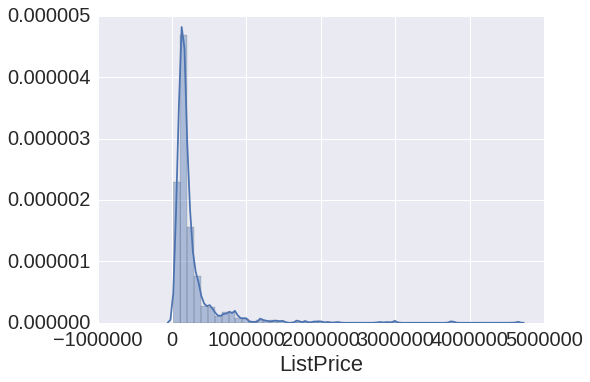

In [25]:
sns.distplot(yy)
plt.show()

In [26]:
mean_price = np.mean(yy)
mean_price

271408.0207020702

In [27]:
stats.ttest_1samp(yy, int(mean_price))
#here we see again that the p-value is large enough to not reject the null hypothesis
#The average price is representative of our population

Ttest_1sampResult(statistic=1.84970211601657e-06, pvalue=0.99999852448360049)

#### sqft

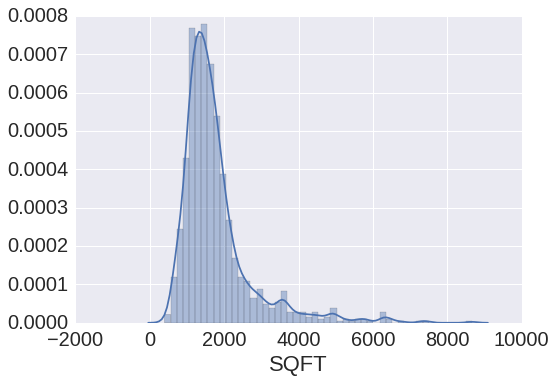

In [28]:
sns.distplot(XX['SQFT'])
plt.show()

In [29]:
mean_sqft = np.mean(XX['SQFT'])
mean_sqft #this is our best estimate for the population mean

1781.7020702070206

In [30]:
stats.ttest_1samp(XX['SQFT'], int(mean_sqft))
#we cannot reject the null hypothesis that the average mean is the one above and this makes sense
#since the distribution is like a bell-shaped curve

Ttest_1sampResult(statistic=0.023877952509503059, pvalue=0.98095425231306421)

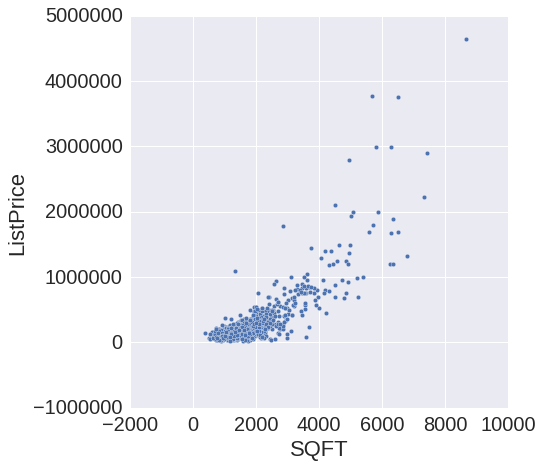

In [31]:
sns.pairplot(data=df, x_vars=['SQFT'], y_vars=['ListPrice'], size=7)
plt.show()

In [32]:
stats.pearsonr(XX['SQFT'], yy)

(0.82777658743402061, 1.2905295169539696e-280)

We see that there is a very strong correlation among SQFT and the response which here is the listing price. We also see that the chance of having such a strong correlation from an uncorrelated dataset are practically zero

#### lot-size

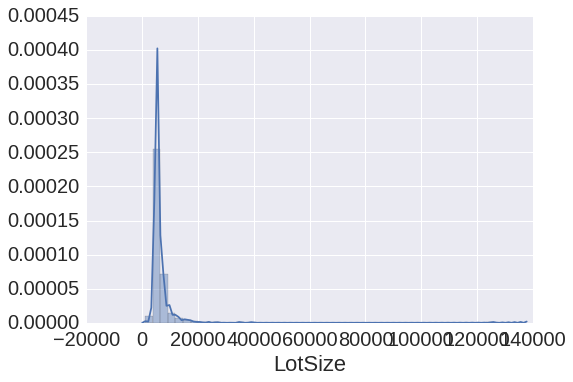

In [33]:
sns.distplot(XX['LotSize'])
plt.show()

In [34]:
mean_lot_size = np.mean(XX['LotSize'])
mean_lot_size

6671.013474958696

In [35]:
stats.ttest_1samp(XX['LotSize'], int(mean_lot_size))
#again the average lot size will be very near 6671

Ttest_1sampResult(statistic=6.2739822727816616e-05, pvalue=0.99994995213743998)

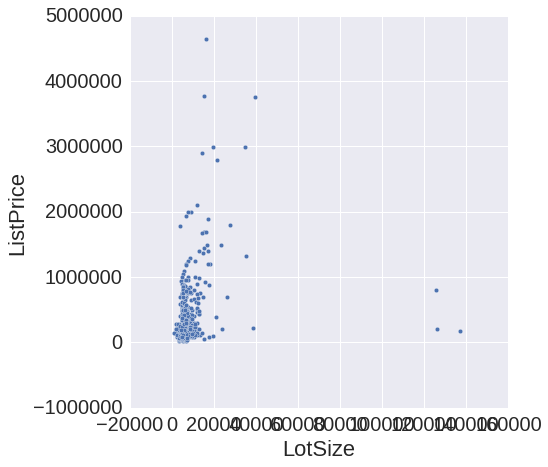

In [36]:
sns.pairplot(data=df, x_vars=['LotSize'], y_vars=['ListPrice'], size=7)
plt.show()

In [37]:
stats.pearsonr(XX['LotSize'], yy)

(0.26627812074686019, 1.7324028743159359e-19)

Here we see that the correlation between the lotsize and the price is not as strong but there is still very small chance of having an uncorrelated system produce datasets which have such correlation

#### bedrooms

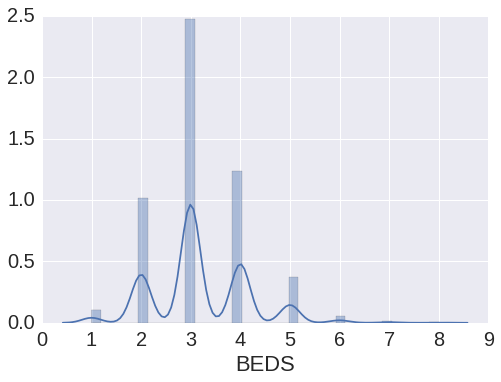

In [38]:
sns.distplot(XX['BEDS'])
plt.show()

In [39]:
mean_beds = np.mean(XX['BEDS'])
mean_beds, int(mean_beds)

(3.189018901890189, 3)

In [40]:
stats.ttest_1samp(XX['BEDS'], 3)
#p-value is too small here and thus we have to reject the null-hypothesis that nothing will happen if we
#assume that the average number of bedrooms is equal to 3
#Here the distribution is not gaussian

Ttest_1sampResult(statistic=6.6038512447557851, pvalue=6.1988157001124448e-11)

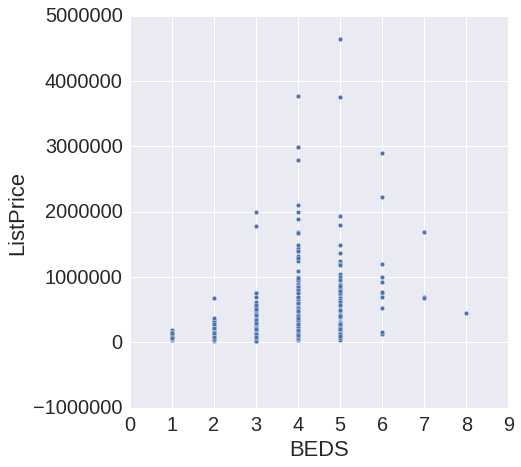

In [41]:
sns.pairplot(data=df, x_vars=['BEDS'], y_vars=['ListPrice'], size=7)
plt.show()

In [42]:
stats.pearsonr(XX['BEDS'], yy)

(0.40693944173137292, 1.4792088562708089e-45)

The number of bedrooms are somewhat correlated with the price and the p-value is almost zero

#### Conclusion
To summarize from above we have this order: LotSize < Bedrooms < SQFT
Which makes sense. People will pay more for a larger area and they care how many bedrooms are available, but the people will appreciate more if the house is bigger rather than if there is a lot of available ground which is just a plain field without anything built on top of it

#### Correlation among variable

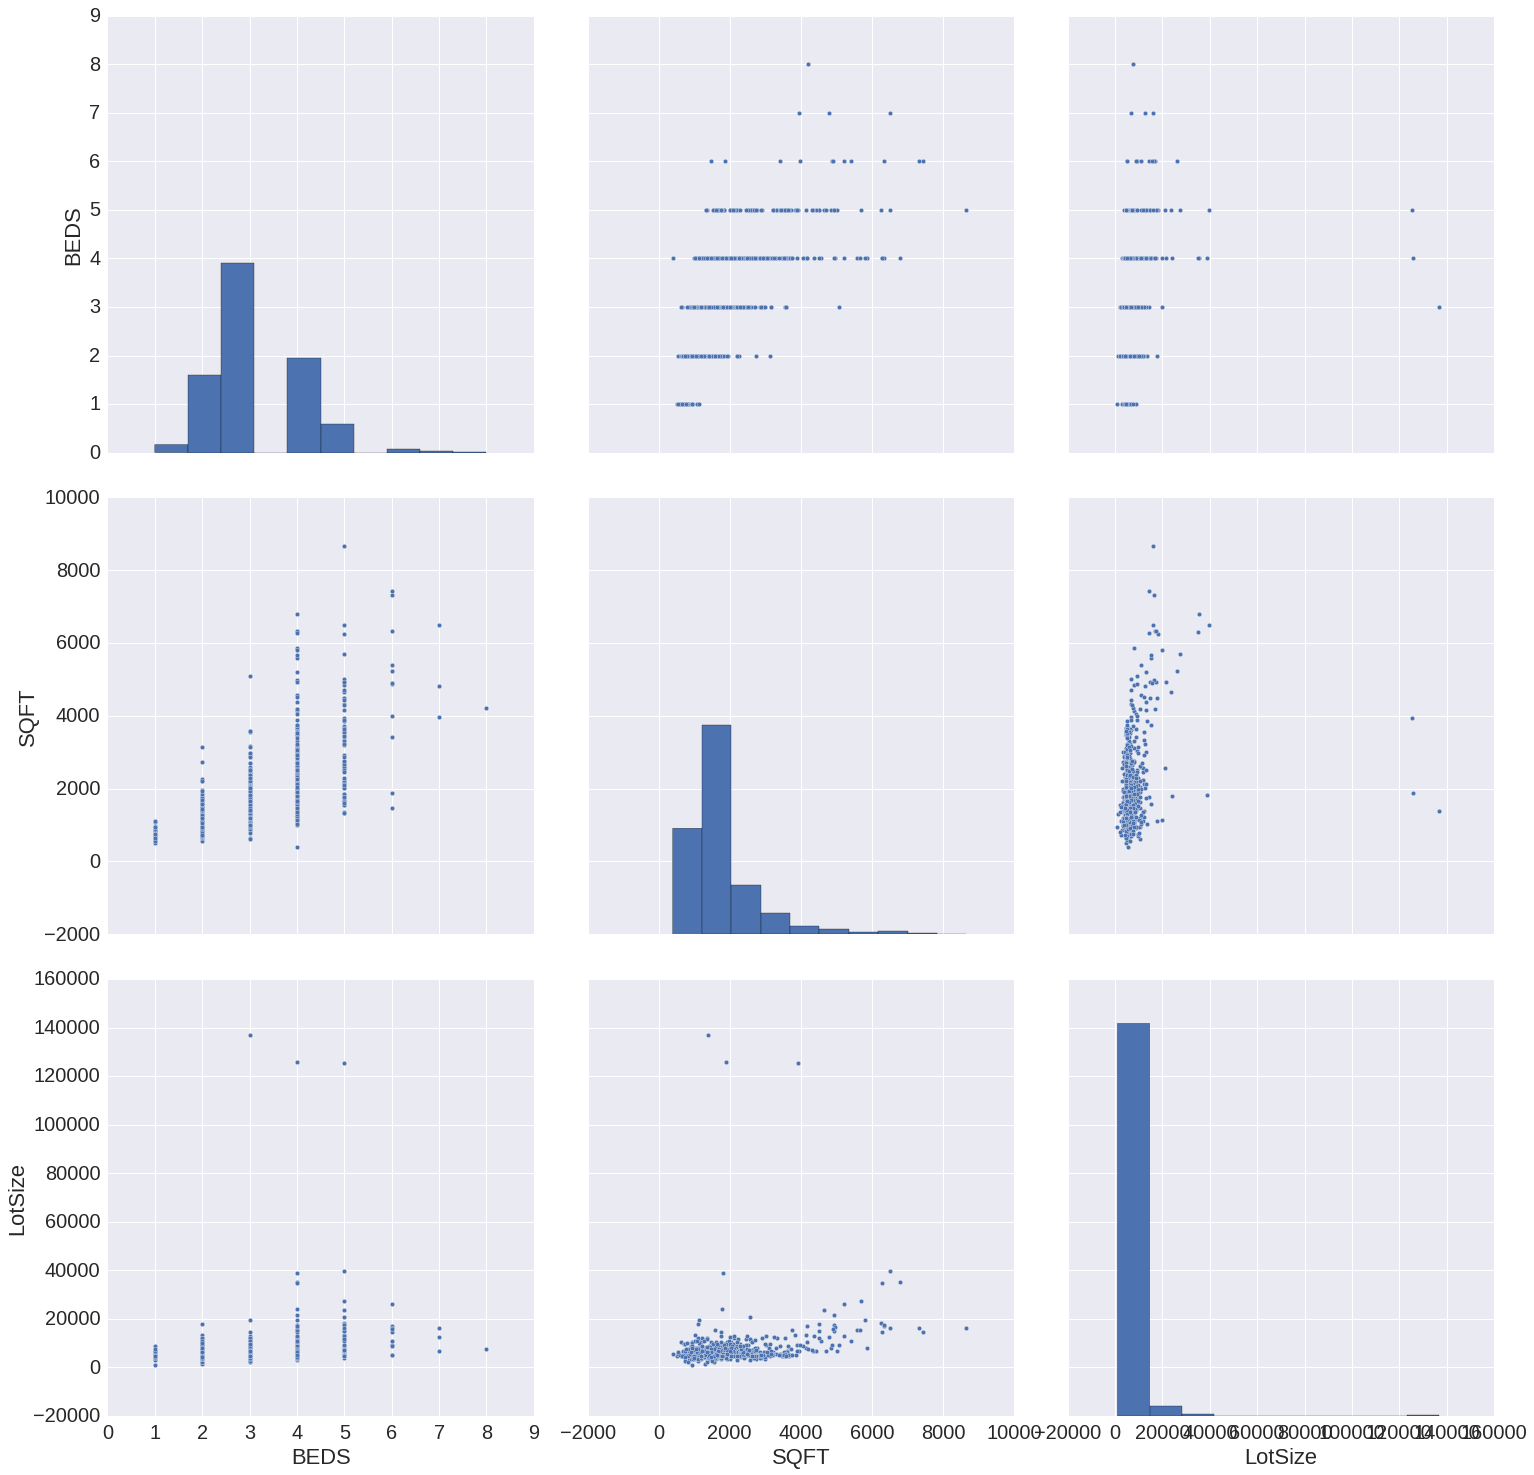

In [43]:
sns.pairplot(XX, vars=['BEDS', 'SQFT', 'LotSize'], size=7)
plt.show()

## Alternatively
Alternatively we can use a machine learning method to build a predictive model for the price using each individual feature, and measure the performance of each model

#### SQFT

In [44]:
X_sqft = XX[['SQFT']]
X_sqft.shape

(1111, 1)

In [45]:
X_sqft2 = X_sqft.copy()
X_sqft2['SQFT2'] = X_sqft2['SQFT']**2
X_sqft2.shape

(1111, 2)

In [46]:
X_sqft3 = X_sqft.copy()
X_sqft3['SQFT2'] = X_sqft3['SQFT']**2
X_sqft3['SQFT3'] = X_sqft3['SQFT']**3
X_sqft3.shape

(1111, 3)

In [47]:
nn = len(XX)

In [48]:
train_inds = random_state.choice(range(nn), size=int(0.8*nn), replace=False)
train_inds.shape

(888,)

In [49]:
test_inds = np.array(list(set(range(nn)).difference(train_inds))) 
test_inds.shape

(223,)

In [50]:
assert len(test_inds) + len(train_inds) == nn

In [51]:
np.all(np.in1d(train_inds, range(nn)))

True

In [52]:
X_train = {
    1: X_sqft.values[train_inds],
    2: X_sqft2.values[train_inds],
    3: X_sqft3.values[train_inds],
}

In [53]:
y_train = yy[train_inds]
y_train.shape

(888,)

In [54]:
X_test = {
    1: X_sqft.values[test_inds],
    2: X_sqft2.values[test_inds],
    3: X_sqft3.values[test_inds],
}
y_test = yy[test_inds]
y_test.shape

(223,)

In [55]:
def cross_valid(alpha, deg, cv=10, normalize=True):
    return np.mean(cross_val_score(estimator=Ridge(alpha=alpha, normalize=normalize), X=X_train[deg],
                                   y=y_train, cv=cv))

In [56]:
alphas = np.logspace(start=-6, stop=0, num=100)

In [57]:
scores = OrderedDict()
best_params = None
best_cv_score = float('-inf')

In [58]:
%%time
for degree in range(1, 3+1):
    for alpha in alphas:
        cur_score = cross_valid(alpha=alpha, deg=degree)
        scores[(alpha, degree)] = cur_score
        if  cur_score > best_cv_score:
            best_cv_score = cur_score
            best_params = alpha, degree

CPU times: user 8.35 s, sys: 0 ns, total: 8.35 s
Wall time: 8.36 s


In [59]:
best_params

(0.070548023107186456, 2)

In [60]:
best_alpha = best_params[0]
best_degree = best_params[1]

In [61]:
Ridge(alpha=best_alpha, normalize=True).fit(X_train[best_degree], y_train).score(X_test[best_degree], y_test)

0.79325375696925726

#### BEDROOMS

In [62]:
def score_attribute(attrname):
    X1 = XX[[attrname]]
    X2 = X1.copy()
    X2[attrname + '2'] = X2[attrname]**2
    X3 = X2.copy()
    X3[attrname + '3'] = X3[attrname]**3
    #print X1.shape, X2.shape, X3.shape
    nn = len(XX)
    train_inds = random_state.choice(range(nn), size=int(0.8*nn), replace=False)
    test_inds = np.array(list(set(range(nn)).difference(train_inds)))
    assert len(test_inds) + len(train_inds) == nn
    X_train = {
        1: X1.values[train_inds],
        2: X2.values[train_inds],
        3: X3.values[train_inds],
    }
    y_train = yy[train_inds]
    X_test = {
        1: X1.values[test_inds],
        2: X2.values[test_inds],
        3: X3.values[test_inds],
    }
    y_test = yy[test_inds]
    
    def cross_valid(alpha, deg, cv=10, normalize=True):
        return np.mean(cross_val_score(estimator=Ridge(alpha=alpha, normalize=normalize), X=X_train[deg],
                                   y=y_train, cv=cv))
    
    alphas = np.logspace(start=-6, stop=0, num=100)
    
    scores = OrderedDict()
    best_params = None
    best_cv_score = float('-inf')
    
    for degree in range(1, 3+1):
        for alpha in alphas:
            cur_score = cross_valid(alpha=alpha, deg=degree)
            scores[(alpha, degree)] = cur_score
            if  cur_score > best_cv_score:
                best_cv_score = cur_score
                best_params = alpha, degree
    
    best_alpha = best_params[0]
    best_degree = best_params[1]
    print best_alpha, best_degree
    
    return Ridge(alpha=best_alpha, normalize=True).fit(X_train[best_degree], y_train).score(
        X_test[best_degree], y_test)

In [63]:
%%time
score_attribute('SQFT')

0.215443469003 3
CPU times: user 8.21 s, sys: 0 ns, total: 8.21 s
Wall time: 8.21 s


0.64813541472174019

In [64]:
%%time
score_attribute('BEDS')

0.572236765935 3
CPU times: user 8.29 s, sys: 0 ns, total: 8.29 s
Wall time: 8.29 s


0.11789616012309612

In [65]:
%%time
score_attribute('LotSize')

0.0200923300257 2
CPU times: user 8.57 s, sys: 0 ns, total: 8.57 s
Wall time: 8.57 s


0.22524810416964225

# Alternatively we are building a Linear Regression Model
The params of the linear model should classify those features

In [68]:
features = ['SQFT', 'BEDS', 'LotSize']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(XX[features], yy, train_size = 0.8, test_size=0.2,
                                                    random_state = random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((888, 3), (223, 3), (888,), (223,))

In [70]:
def cv_for_alpha(alpha, cv=10, normalize=True):
    return np.mean(cross_val_score(estimator=Ridge(alpha=alpha, normalize=normalize), X=X_train, y=y_train, cv=cv))

In [71]:
%%time
alpha_scores = OrderedDict()
best_alpha = None
best_cv_score = float('-inf')
for alpha in alphas:
    cur_score = cv_for_alpha(alpha=alpha)
    alpha_scores[alpha] = cur_score
    if  cur_score > best_cv_score:
        best_cv_score = cur_score
        best_alpha = alpha

CPU times: user 3.97 s, sys: 16 ms, total: 3.99 s
Wall time: 4 s


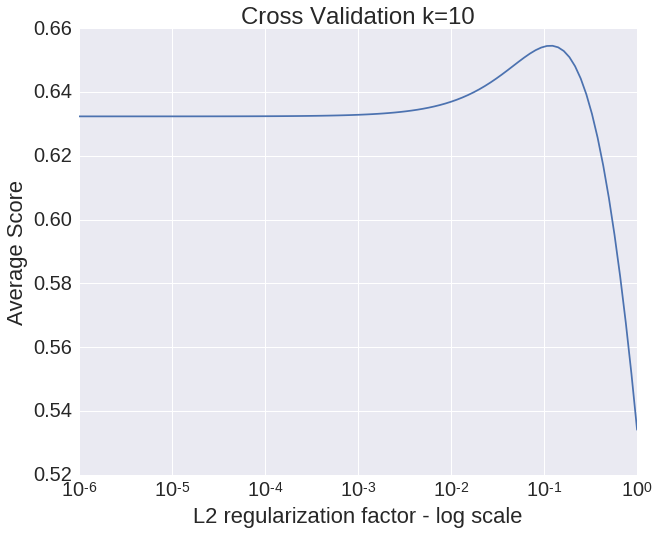

In [72]:
plt.figure(figsize=(10,8))
plt.plot(alpha_scores.keys(), alpha_scores.values())
plt.xscale('log')
plt.xlabel('L2 regularization factor - log scale')
plt.ylabel('Average Score')
plt.title('Cross Validation k=10')
plt.show()

In [73]:
best_alpha

0.12328467394420659

In [75]:
model = Ridge(alpha=best_alpha, normalize=True).fit(X_train, y_train)
model

Ridge(alpha=0.12328467394420659, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=True, random_state=None, solver='auto',
   tol=0.001)

In [76]:
model.score(X_test, y_test)

0.70505261279771414

In [77]:
model.coef_

array([  3.09259585e+02,  -4.02944096e+04,   3.15187073e+00])

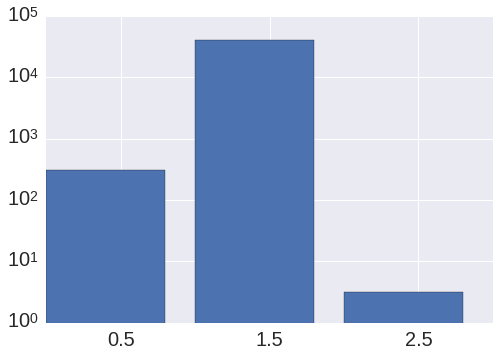

In [83]:
plt.bar(left=[0,1,2], height=np.abs(model.coef_))
plt.xticks([0+.5,1+.5,2+.5])
plt.yscale('log')
plt.show()

## Decision Tree Model

In [118]:
from sklearn.tree import DecisionTreeRegressor

In [119]:
X_train, X_test, y_train, y_test = train_test_split(XX[features], yy, train_size = 0.8, test_size=0.2,
                                                    random_state = random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((888, 3), (223, 3), (888,), (223,))

#### SQFT

In [150]:
estimator = DecisionTreeRegressor(criterion='mae', #because it is more tolerant against outliers
                                  max_depth=1000, #this is a hyperparameter
                                  presort = True, #to speed up the finding of best splits when fitting
                                  )

In [151]:
estimator.fit(X_train[['SQFT']], y_train)

DecisionTreeRegressor(criterion='mae', max_depth=1000, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=True, random_state=None,
           splitter='best')

In [152]:
estimator.score(X_test[['SQFT']], y_test)

0.58103963920696089

#### BEDS

In [147]:
estimator = DecisionTreeRegressor(criterion='mae', #because it is more tolerant against outliers
                                  max_depth=1000, #this is a hyperparameter
                                  presort = True, #to speed up the finding of best splits when fitting
                                  )

In [148]:
estimator.fit(X_train[['BEDS']], y_train)

DecisionTreeRegressor(criterion='mae', max_depth=1000, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=True, random_state=None,
           splitter='best')

In [149]:
estimator.score(X_test[['BEDS']], y_test)

-0.0091739925738312245

#### LotSize

In [144]:
estimator = DecisionTreeRegressor(criterion='mae', #because it is more tolerant against outliers
                                  max_depth=1000, #this is a hyperparameter
                                  presort = True, #to speed up the finding of best splits when fitting
                                  )

In [145]:
estimator.fit(X_train[['LotSize']], y_train)

DecisionTreeRegressor(criterion='mae', max_depth=1000, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=True, random_state=None,
           splitter='best')

In [146]:
estimator.score(X_test[['LotSize']], y_test)

0.42999862635662611